In [2]:
suppressMessages(library(scDesign3))
suppressMessages(library(scales))
suppressMessages(library(dplyr))
suppressMessages(library(ggplot2))
suppressMessages(library(cowplot))
suppressMessages(library(Seurat))

In [3]:
output_dir <- './results'

if(!dir.exists(output_dir)){
    dir.create(output_dir, recursive = TRUE)
}

In [34]:
# 读取本地 VISIUM_sce.rds 文件
ref_sce <- readRDS("./VISIUM_sce.rds")

In [35]:
# remove MT genes
mt_idx<- grep("mt-",rownames(ref_sce))
if(length(mt_idx)!=0){
    ref_sce <- ref_sce[-mt_idx,]
}

In [36]:
ref_sce

class: SingleCellExperiment 
dim: 995 2696 
metadata(0):
assays(2): counts logcounts
rownames(995): Calb2 Gng4 ... Fndc5 Gda
rowData names(0):
colnames(2696): AAACAAGTATCTCCCA-1 AAACACCAATAACTGC-1 ...
  TTGTTTCACATCCAGG-1 TTGTTTCCATACAACT-1
colData names(12): orig.ident nCount_Spatial ... spatial2 cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [ ]:
suppressMessages(library(SingleCellExperiment))
options(repr.plot.height = 4, repr.plot.width = 5)

for(gene in rownames(ref_sce)[5:1]){
    p <- plot_exp(ref_sce, gene = gene, pt_size = 1.2)
    print(p)
}

In [ ]:
# we first select reference genes based on moran'I to
# reduce fitting time for scDesign3
num_genes <- 1
loc <- colData(ref_sce)[, c("spatial1","spatial2")]
features <- FindSpatiallyVariableFeatures(counts(ref_sce), 
                                          spatial.location = loc, 
                                          selection.method = "moransi", 
                                          nfeatures = num_genes)
top.features <- features[order(features$p.value),]
top.features <- rownames(top.features[1:num_genes,])

de_idx <- which(rownames(ref_sce) %in% top.features)
ref_sce <- ref_sce[de_idx, ]

Computing Moran's I

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’

Found more than one class "dist" in cache; using the first, from namespace 'spam'

Also defined by ‘BiocGenerics’



只保留2个基因试试效果

In [ ]:
ref_sce <- ref_sce[rownames(ref_sce) %in% c("Nrgn", "Calb2"), ]

In [38]:
ref_sce

class: SingleCellExperiment 
dim: 2 2696 
metadata(0):
assays(2): counts logcounts
rownames(2): Calb2 Nrgn
rowData names(0):
colnames(2696): AAACAAGTATCTCCCA-1 AAACACCAATAACTGC-1 ...
  TTGTTTCACATCCAGG-1 TTGTTTCCATACAACT-1
colData names(12): orig.ident nCount_Spatial ... spatial2 cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [8]:
plot_exp <- function(sce, gene, pt_size=1){
    df_loc <- colData(sce)[, c("spatial1","spatial2")]
    df_exp <- as.data.frame(counts(sce)[gene, ])
    colnames(df_exp) <- c('exp')
    df_exp$exp <- rescale(log1p(df_exp$exp))
    
    df <- cbind(df_exp, df_loc)
    
    p <- ggplot(data = df, aes(x = spatial1, y = spatial2)) +
    geom_point(aes(color = exp), size = pt_size) +
    scale_colour_gradientn(colors = viridis_pal(option = "magma")(10), limits=c(0, 1)) +
    theme_cowplot() +
    theme(axis.text = element_blank(), axis.ticks = element_blank()) +
    ggtitle(gene)
    
    return(p)
}

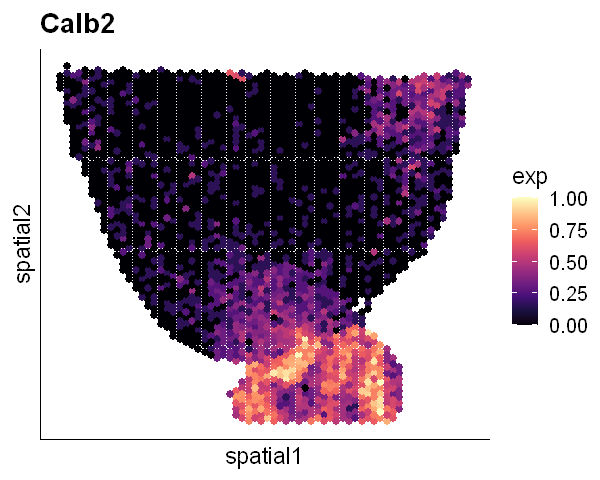

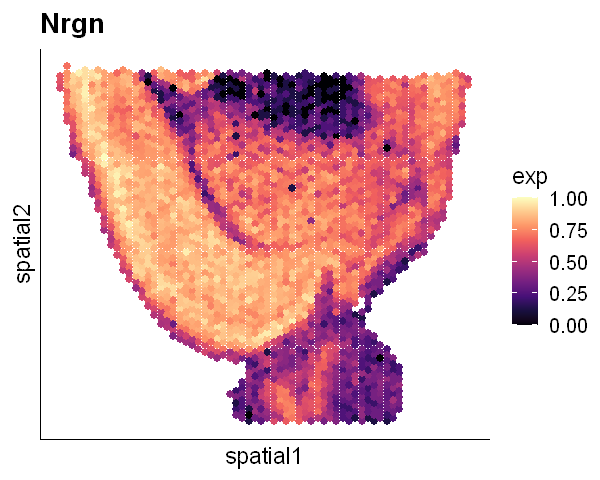

In [43]:
options(repr.plot.height = 4, repr.plot.width = 5)

for(gene in rownames(ref_sce)){
    p <- plot_exp(ref_sce, gene = gene, pt_size = 1.7)
    print(p)
}

In [44]:
set.seed(2024)

In [46]:
# constructs the input data for fit_marginal.
ref_data <- construct_data(
    sce = ref_sce,
    assay_use = "counts",
    celltype = "cell_type",
    pseudotime = NULL,
    spatial = c("spatial1", "spatial2"),
    other_covariates = NULL,
    corr_by = "1"
)

# fit expression of each gene with GP model
ref_marginal <- fit_marginal(
    data = ref_data,
    predictor = "gene",
    mu_formula = "s(spatial1, spatial2, bs = 'gp', k = 500)", 
    sigma_formula = "1",
    family_use = "nb",
    n_cores = 2,
    usebam = FALSE,
    trace = TRUE
  )

dev_explain <- sapply(ref_marginal, function(x){
  sum = summary(x$fit)
  return(sum$dev.expl)
})
dev_ordered <- order(dev_explain, decreasing = TRUE)
num_de <- 50
ordered <- dev_explain[dev_ordered]
sel_genes <- names(ordered)[1:num_de]

ref_para <- extract_para(
    sce = ref_sce,
    marginal_list = ref_marginal,
    n_cores = 5,
    family_use = "nb",
    new_covariate = ref_data$newCovariate,
    data = ref_data$dat
  )

dev_explain <- sapply(ref_marginal, function(x){
  sum = summary(x$fit)
  return(sum$dev.expl)
})
dev_ordered <- order(dev_explain, decreasing = TRUE)
num_de <- min(50, length(dev_explain))  # 自动适配基因数
ordered <- dev_explain[dev_ordered]
sel_genes <- names(ordered)[1:num_de]

In [47]:
ref_sce <- ref_sce[sel_genes, ]

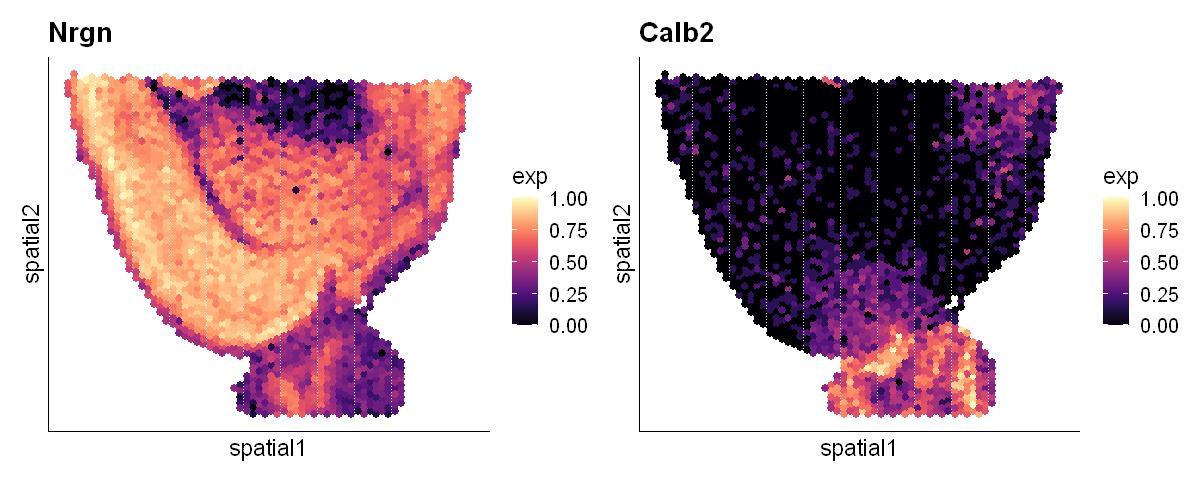

In [73]:
options(repr.plot.height = 4, repr.plot.width = 10)

p1 <- plot_exp(ref_sce, gene='Nrgn', pt_size = 1.7)
p2 <- plot_exp(ref_sce, gene='Calb2', pt_size = 1.7)

print(p1 + p2)

In [50]:
# constructs the input data for fit_marginal.
ref_data <- construct_data(
    sce = ref_sce,
    assay_use = "counts",
    celltype = "cell_type",
    pseudotime = NULL,
    spatial = c("spatial1", "spatial2"),
    other_covariates = NULL,
    corr_by = "1"
)

# fit expression of each gene with GP model
ref_marginal <- fit_marginal(
    data = ref_data,
    predictor = "gene",
    mu_formula = "s(spatial1, spatial2, bs = 'gp', k = 500)", 
    sigma_formula = "1",
    family_use = "nb",
    n_cores = 2,
    usebam = FALSE,
    trace = TRUE
  )

ref_copula <- fit_copula(
    sce = ref_sce,
    assay_use = "counts",
    marginal_list = ref_marginal,
    family_use = "nb",
    copula = "gaussian",
    n_cores = 2,
    input_data = ref_data$dat
)

ref_para <- extract_para(
    sce = ref_sce,
    marginal_list = ref_marginal,
    n_cores = 5,
    family_use = "nb",
    new_covariate = ref_data$newCovariate,
    data = ref_data$dat
  )

Convert Residuals to Multivariate Gaussian

Loading required namespace: SingleCellExperiment


Loading required namespace: SingleCellExperiment


Converting End

Copula group 1 starts



In [52]:
# 确保变量在全局环境
ref_para <- ref_para
ref_sce <- ref_sce
ref_data <- ref_data
ref_copula <- ref_copula
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8756313,467.7,12731152,680.0,12731152,680.0
Vcells,21176467,161.6,39166746,298.9,38965902,297.3


In [54]:
sim_count <- simu_new(
        sce = ref_sce,
        mean_mat = ref_para$mean_mat,
        sigma_mat = ref_para$sigma_mat,
        zero_mat = ref_para$zero_mat,
        quantile_mat = NULL,
        copula_list = ref_copula$copula_list,
        n_cores = 1,
        family_use = "nb",
        input_data = ref_data$dat,
        new_covariate = ref_data$newCovariate,
        important_feature = rep(TRUE, dim(ref_sce)[1]),
        filtered_gene = NULL)

sim_sce <- SingleCellExperiment(list(counts = sim_count), 
                                colData = ref_data$newCovariate)

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts



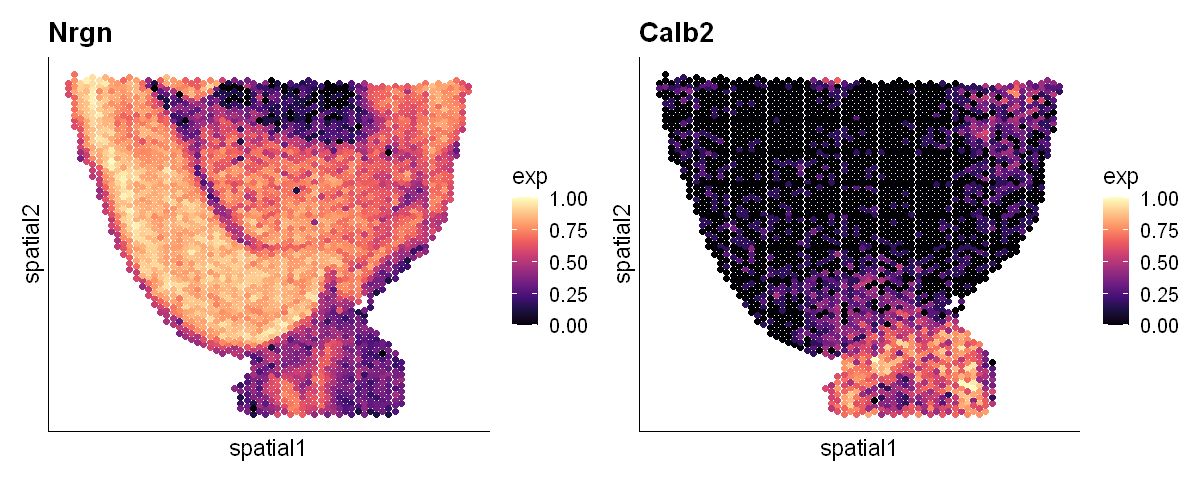

In [56]:
options(repr.plot.height = 4, repr.plot.width = 10)

p1 <- plot_exp(ref_sce, gene='Nrgn', pt_size = 1.5)
p2 <- plot_exp(sim_sce, gene='Calb2', pt_size = 1.5)

print(p1 + p2)

In [57]:
# generate non-spatially variable mean values with shuffling
shuffle_idx <- sample(nrow(ref_para$mean_mat))
non_de_mat <- ref_para$mean_mat[shuffle_idx, ]

In [ ]:
sim_count1 <- simu_new(
        sce = ref_sce,
        mean_mat = 0.8 * ref_para$mean_mat + 0.2 * non_de_mat,
        sigma_mat = ref_para$sigma_mat,
        zero_mat = ref_para$zero_mat,
        quantile_mat = NULL,
        copula_list = ref_copula$copula_list,
        n_cores = 1,
        family_use = "nb",
        input_data = ref_data$dat,
        new_covariate = ref_data$newCovariate,
        important_feature = rep(TRUE, dim(ref_sce)[1]),
        filtered_gene = NULL)

sim_sce1 <- SingleCellExperiment(list(counts =sim_count1), 
                                colData = ref_data$newCovariate)

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts



In [69]:
sim_count2 <- simu_new(
        sce = ref_sce,
        mean_mat = 0.6 * ref_para$mean_mat + 0.4 * non_de_mat,
        sigma_mat = ref_para$sigma_mat,
        zero_mat = ref_para$zero_mat,
        quantile_mat = NULL,
        copula_list = ref_copula$copula_list,
        n_cores = 1,
        family_use = "nb",
        input_data = ref_data$dat,
        new_covariate = ref_data$newCovariate,
        important_feature = rep(TRUE, dim(ref_sce)[1]),
        filtered_gene = NULL)

sim_sce2 <- SingleCellExperiment(list(counts =sim_count2), 
                                colData = ref_data$newCovariate)

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts



In [78]:
sim_count3 <- simu_new(
        sce = ref_sce,
        mean_mat = 0.4 * ref_para$mean_mat + 0.6 * non_de_mat,
        sigma_mat = ref_para$sigma_mat,
        zero_mat = ref_para$zero_mat,
        quantile_mat = NULL,
        copula_list = ref_copula$copula_list,
        n_cores = 1,
        family_use = "nb",
        input_data = ref_data$dat,
        new_covariate = ref_data$newCovariate,
        important_feature = rep(TRUE, dim(ref_sce)[1]),
        filtered_gene = NULL)

sim_sce3 <- SingleCellExperiment(list(counts =sim_count3), 
                                colData = ref_data$newCovariate)

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts



In [79]:
sim_count4 <- simu_new(
        sce = ref_sce,
        mean_mat = 0.2 * ref_para$mean_mat + 0.8 * non_de_mat,
        sigma_mat = ref_para$sigma_mat,
        zero_mat = ref_para$zero_mat,
        quantile_mat = NULL,
        copula_list = ref_copula$copula_list,
        n_cores = 1,
        family_use = "nb",
        input_data = ref_data$dat,
        new_covariate = ref_data$newCovariate,
        important_feature = rep(TRUE, dim(ref_sce)[1]),
        filtered_gene = NULL)

sim_sce4 <- SingleCellExperiment(list(counts =sim_count4), 
                                colData = ref_data$newCovariate)

Use Copula to sample a multivariate quantile matrix

Sample Copula group 1 starts



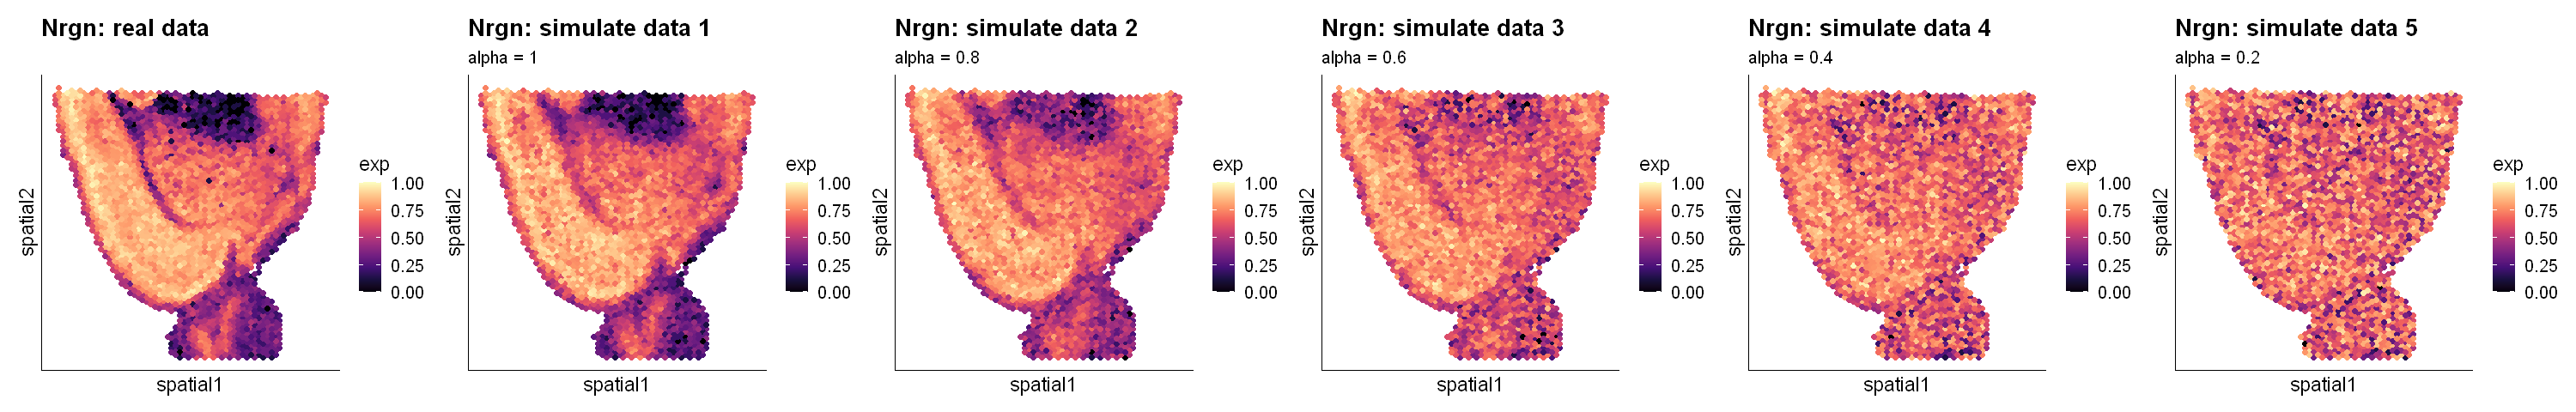

In [80]:
options(repr.plot.height = 4, repr.plot.width = 25)

library(patchwork)

p1 <- plot_exp(ref_sce, gene='Nrgn', pt_size = 1.5) + 
    ggtitle("Nrgn: real data") 
p2 <- plot_exp(sim_sce, gene='Nrgn', pt_size = 1.5) + 
    ggtitle("Nrgn: simulate data 1") + 
    labs(subtitle = "alpha = 1")
p3 <- plot_exp(sim_sce1, gene='Nrgn', pt_size = 1.5) + 
    ggtitle("Nrgn: simulate data 2") + 
    labs(subtitle = "alpha = 0.8")
p4 <- plot_exp(sim_sce2, gene='Nrgn', pt_size = 1.5) + 
    ggtitle("Nrgn: simulate data 3") + 
    labs(subtitle = "alpha = 0.6")
p5 <- plot_exp(sim_sce3, gene='Nrgn', pt_size = 1.5) + 
    ggtitle("Nrgn: simulate data 4") + 
    labs(subtitle = "alpha = 0.4")
p6 <- plot_exp(sim_sce4, gene='Nrgn', pt_size = 1.5) + 
    ggtitle("Nrgn: simulate data 5") + 
    labs(subtitle = "alpha = 0.2")

print(p1 + p2 + p3 + p4 + p5 + p6 + plot_layout(ncol = 6))

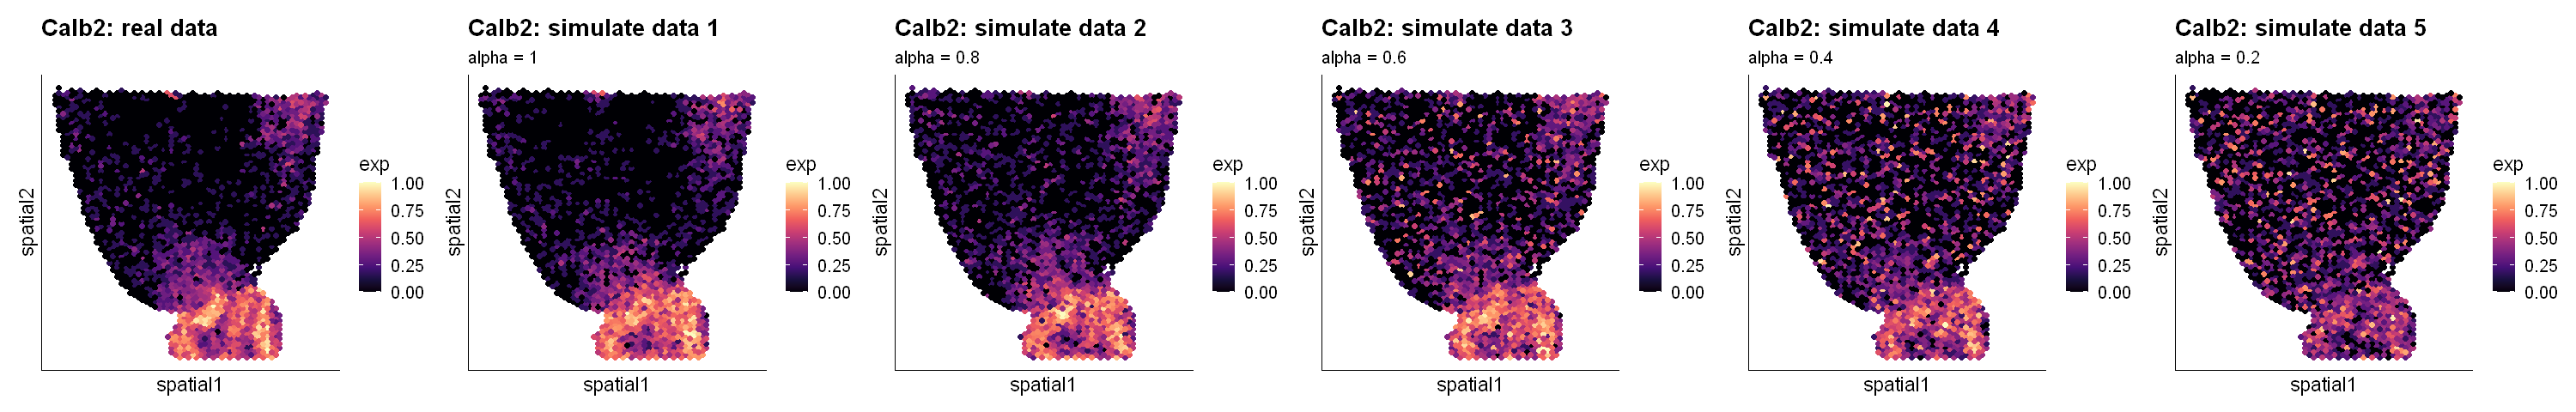

In [81]:
options(repr.plot.height = 4, repr.plot.width = 25)

library(patchwork)

p1 <- plot_exp(ref_sce, gene='Calb2', pt_size = 1.5) + 
    ggtitle("Calb2: real data") 
p2 <- plot_exp(sim_sce, gene='Calb2', pt_size = 1.5) + 
    ggtitle("Calb2: simulate data 1") + 
    labs(subtitle = "alpha = 1")
p3 <- plot_exp(sim_sce1, gene='Calb2', pt_size = 1.5) + 
    ggtitle("Calb2: simulate data 2") + 
    labs(subtitle = "alpha = 0.8")
p4 <- plot_exp(sim_sce2, gene='Calb2', pt_size = 1.5) + 
    ggtitle("Calb2: simulate data 3") + 
    labs(subtitle = "alpha = 0.6")
p5 <- plot_exp(sim_sce3, gene='Calb2', pt_size = 1.5) + 
    ggtitle("Calb2: simulate data 4") + 
    labs(subtitle = "alpha = 0.4")
p6 <- plot_exp(sim_sce4, gene='Calb2', pt_size = 1.5) + 
    ggtitle("Calb2: simulate data 5") + 
    labs(subtitle = "alpha = 0.2")

print(p1 + p2 + p3 + p4 + p5 + p6 + plot_layout(ncol = 6))

In [ ]:
# simulate data with varied spatial variability
count <- lapply(seq(0, 1.0, 0.05), function(alpha){
    sim_count <- simu_new(
        sce = ref_sce,
        mean_mat =  alpha * ref_para$mean_mat + (1 - alpha) * non_de_mat,
        sigma_mat = ref_para$sigma_mat,
        zero_mat = ref_para$zero_mat,
        quantile_mat = NULL,
        copula_list = ref_copula$copula_list,
        n_cores = 1,
        family_use = "nb",
        input_data = ref_data$dat,
        new_covariate = ref_data$newCovariate,
        important_feature = rep(TRUE, dim(ref_sce)[1]),
        filtered_gene = NULL)

    rownames(sim_count) <- paste0(rownames(sim_count), "_", alpha)
    
    return(sim_count)

}) %>% do.call(rbind, .)

In [ ]:
# save simulated data
write.csv(ref_data$newCovariate, file = glue::glue("{output_dir}/location.csv"))
write.csv(count, file = glue::glue('{output_dir}/counts.csv'))